In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import *

## Load and Preprocess Data

In [2]:
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()

In [3]:
def generate_image_pairs_with_labels(images, classes):
    image_pairs = []
    labels = []
    sample = lambda x, s: x[np.random.choice(x.shape[0], s)]
    
    for i in range(10):
        similar = images[classes == i]
        non_similar = images[classes != i]
        size = similar.shape[0] // 2
        image_pairs.append([similar, np.concatenate([sample(similar, size), sample(non_similar, size)])])
        labels.append(np.concatenate([np.ones(size), np.zeros(size)]))
        
    image_pairs = np.concatenate(image_pairs, axis=1) / 255.0
    labels = np.concatenate(labels)
    indices = np.random.permutation(labels.shape[0])
    return image_pairs[:, indices], labels[indices]

In [4]:
train_image_pairs, train_labels = generate_image_pairs_with_labels(X_train, y_train)
test_image_pairs, test_labels = generate_image_pairs_with_labels(X_test, y_test)

In [135]:
def visualize_image_similarity(image_pairs, labels, examples=6, distances=None, threshold=0.5):
    x1, x2 = image_pairs
    i = np.random.randint(0, x1.shape[0] - examples)
    k = 1
    plt.figure(figsize=(5 * examples, 10))
    for img in x1[i : i + examples]:
        plt.subplot(2, examples, k)
        plt.imshow(img, cmap='gray')
        label = labels[i + k - 1]
        plt.title(label, fontdict={'fontsize': 50, 'color': 'r' if label < threshold else 'g'})
        k += 1
        plt.xticks([])
        plt.yticks([])
    for img in x2[i : i + examples]:
        plt.subplot(2, examples, k)
        plt.imshow(img, cmap='gray')
        if np.sum(distances) != None:
            dist = np.round(distances[i + k - 1][0], 4)
            plt.xlabel(dist, fontdict={'fontsize': 35, 'color': 'g' if dist < threshold else 'r'})
        k += 1
        plt.xticks([])
        plt.yticks([])

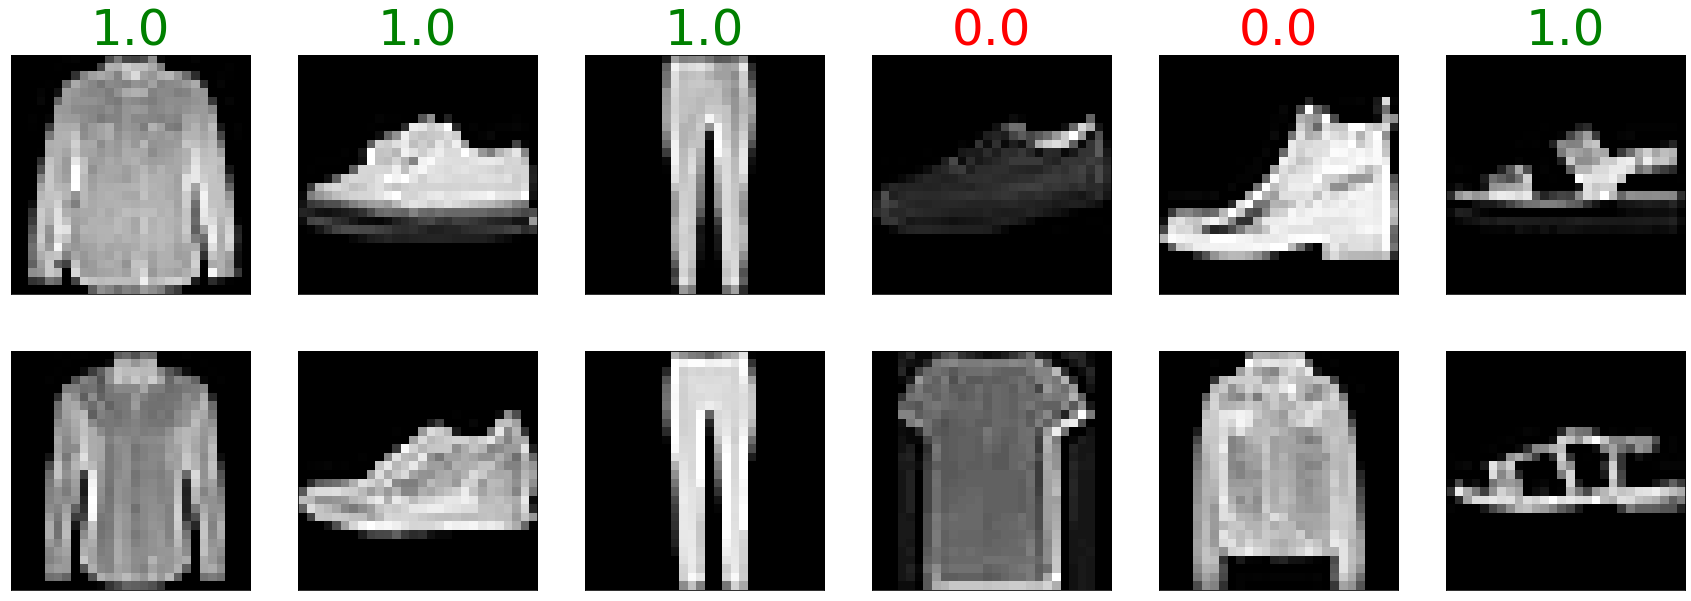

In [136]:
visualize_image_similarity(train_image_pairs, train_labels)

## Custom Loss as a Class

In [92]:
class ContrastiveLoss(losses.Loss):
    def __init__(self, margin=1):
        super().__init__()
        self.margin = margin
    
    def call(self, y_true, y_pred):
        margin_sq = tf.maximum(self.margin - y_pred, 0)
        return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(margin_sq))